In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#ID 컬럼 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [4]:
train.head()

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률
0,2009,CT005,이커머스,Series A,4126.0,No,No,56.0,3365.0,4764.0,4.71,NaN,0.3
1,2023,CT006,핀테크,Seed,4167.0,Yes,No,80.0,4069.0,279.0,1.00,2500-3500,0.8
2,2018,CT007,기술,Series A,3132.0,Yes,Yes,54.0,6453.0,12141.0,4.00,3500-4500,0.5
3,2016,CT006,NaN,Seed,3245.0,Yes,Yes,NaN,665.0,10547.0,2.97,NaN,0.7
4,2020,CT002,에듀테크,Seed,1969.0,No,Yes,94.0,829.0,9810.0,1.00,1500-2500,0.1


In [5]:
import re

def clean_valuation(val):
    if pd.isna(val):
        return None
    if '이상' in val:
        # '6000이상' → 6000
        return int(re.sub('[^0-9]', '', val))
    elif '-' in val:
        # '2500-3500' → 평균값 계산
        low, high = map(int, val.split('-'))
        return (low + high) / 2
    else:
        # 숫자로 변환 가능한 경우
        try:
            return float(val)
        except:
            return None


In [6]:
# 설립연도 -> 연차로 변경
current_year = 2025

train['연차'] = current_year - train['설립연도']
test['연차'] = current_year - test['설립연도']

# 설립연도 제거
train.drop(columns = ['설립연도'], inplace = True)
test.drop(columns = ['설립연도'], inplace = True)

category_features = ['국가','분야']
numeric_features = ['연차', '투자단계', '직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)', '기업가치(백억원)']
bool_features = ['인수여부','상장여부']

# 투자단계 순서를 숫자로 매핑
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# 결측치 먼저 처리 후 매핑
train['투자단계'] = train['투자단계'].fillna('Missing').map(investment_stage_map)
test['투자단계'] = test['투자단계'].fillna('Missing').map(investment_stage_map)

# 기업가치 변환
train['기업가치(백억원)'] = train['기업가치(백억원)'].apply(clean_valuation)
test['기업가치(백억원)'] = test['기업가치(백억원)'].apply(clean_valuation)

# LabelEncoder 객체를 각 범주형 feature별로 따로 저장하여 사용
encoders = {}

# 범주형 데이터를 encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# 불리언 값을 0과 1로 변환 ('Yes' → 1, 'No' → 0 으로 변환)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# 수치형 변수 결측치를 중간값으로 대체
for feature in numeric_features:
    median_value = train[feature].median()
    train[feature] = train[feature].fillna(median_value)
    test[feature] = test[feature].fillna(median_value)

# TabNet용 범주형 변수 인덱스(cat_idxs) 및 차원(cat_dims) 설정
features = [col for col in train.columns if col != '성공확률']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [7]:
# 1인당 지표
train['투자_1인당'] = train['총 투자금(억원)'] / train['직원 수']
train['매출_1인당'] = train['연매출(억원)'] / train['직원 수']

# 비율 지표
train['투자대비매출'] = train['연매출(억원)'] / (train['총 투자금(억원)'] + 1e-6)  # 0 나누기 방지
train['가치대비투자비율'] = train['총 투자금(억원)'] / (train['기업가치(백억원)'] + 1e-6)
train['고객당매출'] = train['연매출(억원)'] / (train['고객수(백만명)'] + 1e-6)

# 스케일 변환
train['연차_루트'] = np.sqrt(train['연차'])


In [8]:
test['투자_1인당'] = test['총 투자금(억원)'] / test['직원 수']
test['매출_1인당'] = test['연매출(억원)'] / test['직원 수']
test['투자대비매출'] = test['연매출(억원)'] / (test['총 투자금(억원)'] + 1e-6)
test['가치대비투자비율'] = test['총 투자금(억원)'] / (test['기업가치(백억원)'] + 1e-6)
test['고객당매출'] = test['연매출(억원)'] / (test['고객수(백만명)'] + 1e-6)
test['연차_루트'] = np.sqrt(test['연차'])


In [9]:
features += [
    '투자_1인당', '매출_1인당', '투자대비매출',
    '가치대비투자비율', '고객당매출', '연차_루트'
]


In [10]:
for df in [train, test]:
    df['투자_회수율'] = df['기업가치(백억원)'] / (df['총 투자금(억원)'] + 1e-6)
    df['SNS_노출도'] = df['SNS 팔로워 수(백만명)'] / (df['고객수(백만명)'] + 1e-6)
    df['SNS_영향력'] = df['SNS 팔로워 수(백만명)'] / (df['기업가치(백억원)'] + 1e-6)
    df['직원당_고객수'] = df['고객수(백만명)'] / (df['직원 수'] + 1e-6)
    df['연매출_비율'] = df['연매출(억원)'] / (df['기업가치(백억원)'] + 1e-6)
    df['성장도'] = df['연매출(억원)'] / (df['연차'] + 1e-6)


In [11]:
features += [
    '투자_회수율', 'SNS_노출도', 'SNS_영향력',
    '직원당_고객수', '연매출_비율', '성장도'
]


In [12]:
# features 리스트에서 제거
features = [f for f in features if f not in ['국가', '분야', '투자단계']]


In [13]:
features = [f for f in features if f not in ['인수여부', '상장여부', '직원 수']]


In [14]:
features

['고객수(백만명)',
 '총 투자금(억원)',
 '연매출(억원)',
 'SNS 팔로워 수(백만명)',
 '기업가치(백억원)',
 '연차',
 '투자_1인당',
 '매출_1인당',
 '투자대비매출',
 '가치대비투자비율',
 '고객당매출',
 '연차_루트',
 '투자_회수율',
 'SNS_노출도',
 'SNS_영향력',
 '직원당_고객수',
 '연매출_비율',
 '성장도']

In [15]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 1. KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Optuna objective 함수 정의 (KFold 기반)
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 15, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'tree_method': 'hist',
        'seed': 42
    }

    mae_list = []

    for train_idx, valid_idx in kf.split(train[features]):
        X_train, X_valid = train.iloc[train_idx][features], train.iloc[valid_idx][features]
        y_train, y_valid = train.iloc[train_idx]['성공확률'], train.iloc[valid_idx]['성공확률']

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=2000,
            evals=[(dvalid, 'valid')],
            early_stopping_rounds=40,
            verbose_eval=False
        )

        preds = model.predict(dvalid)
        mae = mean_absolute_error(y_valid, preds)
        mae_list.append(mae)

    return np.mean(mae_list)  # 모든 Fold 평균 MAE

# 3. Optuna study 실행
study = optuna.create_study(direction='minimize')  # MAE 작을수록 좋음
study.optimize(objective, n_trials=300)

# 4. 결과 출력
print("✅ Best trial:")
print(study.best_trial)


/Users/hyun/torch_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-10 13:02:44,074] A new study created in memory with name: no-name-9e7b96f0-d0ab-483c-a47f-9f615165bef0
[I 2025-04-10 13:02:46,654] Trial 0 finished with value: 0.19880737985470215 and parameters: {'learning_rate': 0.04105284392385431, 'max_depth': 17, 'subsample': 0.8929889743910846, 'colsample_bytree': 0.6576707240037454, 'lambda': 0.037287667989255875, 'alpha': 0.04523631884010393}. Best is trial 0 with value: 0.19880737985470215.
[I 2025-04-10 13:02:48,082] Trial 1 finished with value: 0.2014996989512055 and parameters: {'learning_rate': 0.08394843193793734, 'max_depth': 15, 'subsample': 0.8880060013980124, 'colsample_bytree': 0.8645619297527531, 'lambda': 0.06351890684823663, 'alpha': 0.004032369683232728}. Best is tri

KeyboardInterrupt: 

In [ ]:
    'learning_rate': 0.01048084799678993,
    'max_depth': 20,
    'subsample': 0.980717046360826,
    'colsample_bytree': 0.6456604619831267,
    'lambda': 0.11417530245559546,
    'alpha': 0.0015849133858274775

In [18]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

X = train[features]
y = train['성공확률']

kf = KFold(n_splits=10, shuffle=True, random_state=42)
models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.03674126205475308,
    'max_depth': 18,
    'subsample': 0.9658901119807219,
    'colsample_bytree': 0.5585452433150189,
    'lambda': 0.06731590651355367,
    'alpha': 0.012920079201935733,
    'tree_method': 'hist',
    'seed': 42
}




for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold+1}/10")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    print(f"  🔍 Fold {fold+1} MAE: {score:.4f}")

    models.append(model)
    cv_scores.append(score)

print("\n✅ 모든 fold 모델 학습 완료!")
print(f"📉 평균 MAE: {sum(cv_scores)/len(cv_scores):.4f}")



🔁 Fold 1/10
[0]	train-mae:0.20009	valid-mae:0.20079
[98]	train-mae:0.01832	valid-mae:0.19579
  🔍 Fold 1 MAE: 0.1958

🔁 Fold 2/10
[0]	train-mae:0.19957	valid-mae:0.20953
[100]	train-mae:0.01892	valid-mae:0.19347
[200]	train-mae:0.00368	valid-mae:0.19287
[300]	train-mae:0.00158	valid-mae:0.19280
[400]	train-mae:0.00125	valid-mae:0.19278
[500]	train-mae:0.00118	valid-mae:0.19278
[600]	train-mae:0.00115	valid-mae:0.19278
[656]	train-mae:0.00115	valid-mae:0.19278
  🔍 Fold 2 MAE: 0.1928

🔁 Fold 3/10
[0]	train-mae:0.19899	valid-mae:0.21021
[100]	train-mae:0.02135	valid-mae:0.20378
[133]	train-mae:0.01174	valid-mae:0.20384
  🔍 Fold 3 MAE: 0.2038

🔁 Fold 4/10
[0]	train-mae:0.19930	valid-mae:0.20080
[100]	train-mae:0.01963	valid-mae:0.19421
[200]	train-mae:0.00379	valid-mae:0.19404
[235]	train-mae:0.00262	valid-mae:0.19401
  🔍 Fold 4 MAE: 0.1940

🔁 Fold 5/10
[0]	train-mae:0.19853	valid-mae:0.20666
[100]	train-mae:0.02246	valid-mae:0.20191
[200]	train-mae:0.00419	valid-mae:0.20174
[218]	train-ma

In [19]:
import xgboost as xgb
import numpy as np

# 저장된 모델들로 예측
predictions_list = []

dtest = xgb.DMatrix(test[features])  # ← 여기가 핵심

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)  # DMatrix 입력
    predictions_list.append(preds)

# 평균 예측
final_predictions = np.mean(predictions_list, axis=0)

# 제출 파일 생성
sample_submission['성공확률'] = final_predictions
sample_submission.to_csv('./0410_08_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10


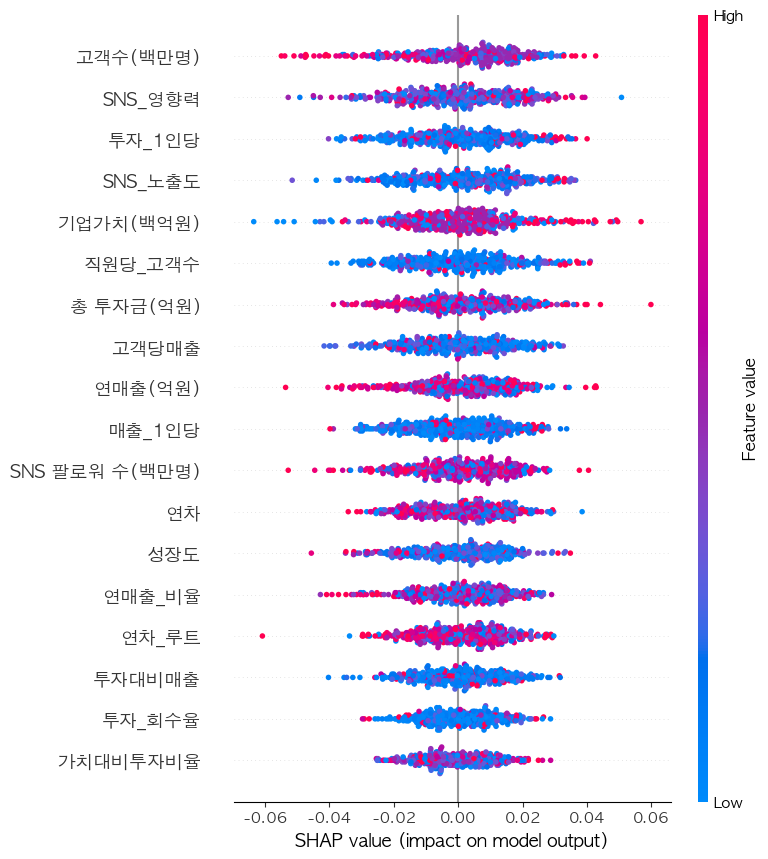

In [33]:
import shap
import matplotlib.pyplot as plt

# macOS: AppleGothic 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)


In [76]:
import pandas as pd

# 가장 성능 좋았던 모델 하나만 기준으로 확인 (예: Trial 32 기반)
best_model = models[np.argmin(cv_scores)]  # MAE 기준 최상 모델

# 중요도 추출
importance = best_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'GainImportance'])
importance_df = importance_df.sort_values(by='GainImportance', ascending=False)

print(importance_df)


           Feature  GainImportance
11          연매출_비율        0.024505
12             성장도        0.023511
4         가치대비투자비율        0.022058
8          SNS_노출도        0.021561
9          SNS_영향력        0.021225
3           투자대비매출        0.020001
7           투자_회수율        0.019836
13            투자단계        0.019667
10         직원당_고객수        0.019619
2           매출_1인당        0.019610
6            연차_루트        0.018359
5            고객당매출        0.018331
1           투자_1인당        0.016516
0   SNS 팔로워 수(백만명)        0.014836


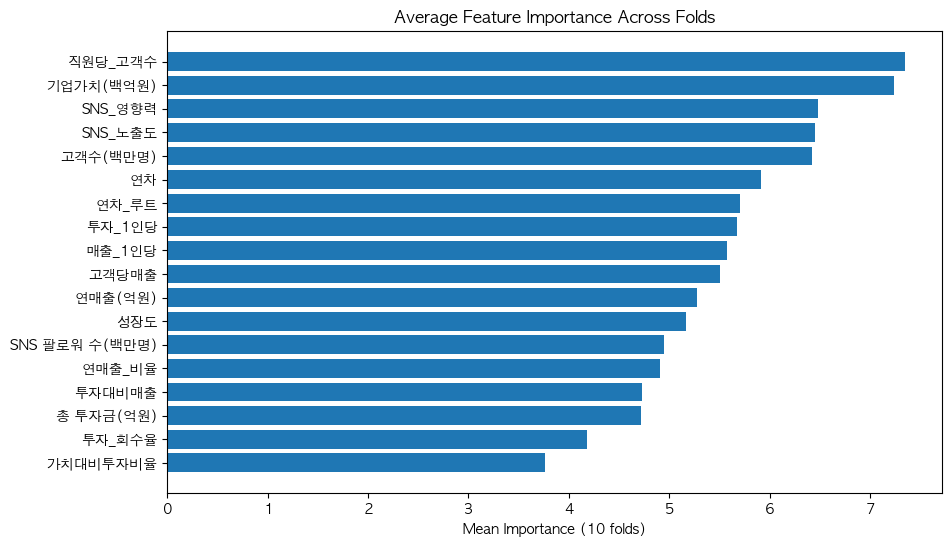

In [34]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# macOS: AppleGothic 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
# 모델별 중요도 수집
all_importances = np.array([model.get_feature_importance() for model in models])

# 평균 중요도 계산
mean_importances = np.mean(all_importances, axis=0)

# 정렬
sorted_idx = np.argsort(mean_importances)[::-1]
sorted_features = np.array(features)[sorted_idx]
sorted_importances = mean_importances[sorted_idx]

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Mean Importance (10 folds)")
plt.title("Average Feature Importance Across Folds")
plt.gca().invert_yaxis()
plt.show()
